# ResNet50 Image Classification

This notebook implements a ResNet50 model to classify images directly without converting them to vectors using img2vec.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Load and Preprocess Data

In [2]:
# Load the CSV files
data_dir = os.path.join( '..', 'data')
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
val_df = pd.read_csv(os.path.join(data_dir, 'val.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))

# Print column names to understand structure
print("Train columns:", train_df.columns.tolist())
print("First few rows of train_df:")
print(train_df.head())


Train columns: ['user_id', 'face_id', 'original_image', 'age', 'gender']
First few rows of train_df:
         user_id  face_id                original_image        age gender
0    9855553@N08     1581  11658657103_4485e3f5ac_o.jpg  (60, 100)      m
1  114841417@N06      502  12059583524_606ca96139_o.jpg   (15, 20)      m
2   66870968@N06     1227  11326189206_e08bdf6dfd_o.jpg   (25, 32)      m
3    8187011@N06      988  11133041085_e2ee5e12cb_o.jpg     (0, 2)      u
4  114841417@N06      485  12059753735_7141b5443c_o.jpg   (15, 20)      f


### Create combined age-gender target column

In [3]:
def construct_img_path(row):
    return os.path.join(data_dir, 'faces', row['user_id'], 
                      f"coarse_tilt_aligned_face.{row['face_id']}.{row['original_image']}")


for df in [train_df, val_df, test_df]:
    # Create simpler gender labels
    df['gender_label'] = df['gender'].map({'m': 'male', 'f': 'female', 'u': 'unknown'})
    
    # Create the combined target column
    df['age_gender'] = df['age'] + '_' + df['gender_label']

    # Construct the image path
    df['image_path'] = df.apply(construct_img_path, axis=1)

### 

In [4]:
# Get unique classes from each dataset
train_classes = set(train_df['age_gender'].unique())
val_classes = set(val_df['age_gender'].unique()) 
test_classes = set(test_df['age_gender'].unique())

# Find common classes across all datasets
common_classes = train_classes.intersection(val_classes, test_classes)

print(f"Total classes in train: {len(train_classes)}")
print(f"Total classes in val: {len(val_classes)}")
print(f"Total classes in test: {len(test_classes)}")
print(f"Common classes across all datasets: {len(common_classes)}")
print("\nCommon classes:")
for cls in sorted(common_classes):
    print(f"- {cls}")

# Filter each dataset to include only common classes
train_df_filtered = train_df[train_df['age_gender'].isin(common_classes)]
val_df_filtered = val_df[val_df['age_gender'].isin(common_classes)]
test_df_filtered = test_df[test_df['age_gender'].isin(common_classes)]

print(f"\nFiltered train samples: {len(train_df_filtered)} (removed {len(train_df) - len(train_df_filtered)})")
print(f"Filtered val samples: {len(val_df_filtered)} (removed {len(val_df) - len(val_df_filtered)})")
print(f"Filtered test samples: {len(test_df_filtered)} (removed {len(test_df) - len(test_df_filtered)})")


Total classes in train: 20
Total classes in val: 18
Total classes in test: 18
Common classes across all datasets: 17

Common classes:
- (0, 2)_female
- (0, 2)_male
- (0, 2)_unknown
- (15, 20)_female
- (15, 20)_male
- (25, 32)_female
- (25, 32)_male
- (38, 43)_female
- (38, 43)_male
- (4, 6)_female
- (4, 6)_male
- (48, 53)_female
- (48, 53)_male
- (60, 100)_female
- (60, 100)_male
- (8, 23)_female
- (8, 23)_male

Filtered train samples: 11851 (removed 5)
Filtered val samples: 2963 (removed 1)
Filtered test samples: 3729 (removed 2)


In [5]:
image_path_col = 'image_path'
label_col = 'age_gender'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df_filtered,
    directory=data_dir,
    x_col=image_path_col,
    y_col=label_col,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    validate_filenames=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df_filtered,
    directory=data_dir,
    x_col=image_path_col,
    y_col=label_col,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    validate_filenames=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df_filtered,
    directory=data_dir,
    x_col=image_path_col,
    y_col=label_col,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    validate_filenames=True,
    shuffle=False
)

# Verify they have the same classes
print("\nAfter filtering:")
print(f"Training classes: {len(train_generator.class_indices)}")
print(f"Validation classes: {len(val_generator.class_indices)}")
print(f"Test classes: {len(test_generator.class_indices)}")

# Set number of classes for model
num_classes = len(train_generator.class_indices)
print(f"Final number of classes for model: {num_classes}")



Found 11851 validated image filenames belonging to 17 classes.
Found 2963 validated image filenames belonging to 17 classes.
Found 3729 validated image filenames belonging to 17 classes.

After filtering:
Training classes: 17
Validation classes: 17
Test classes: 17
Final number of classes for model: 17


### Build the ResNet50 Model
We will use the pre-trained ResNet50 model and add a custom classification head.

In [6]:
# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with categorical crossentropy for multi-class
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,772,497 (94.50 MB)

 Trainable params: 1,184,785 (4.52 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Train the Model
We will use early stopping and model checkpointing to save the best model.

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet50_model.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1395 - loss: 2.7841

371/371 ━━━━━━━━━━━━━━━━━━━━ 634s 2s/step - accuracy: 0.1396 - loss: 2.7839 - val_accuracy: 0.1613 - val_loss: 2.6596
Epoch 2/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.1585 - loss: 2.6839 - val_accuracy: 0.1613 - val_loss: 2.6641
Epoch 3/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1687 - loss: 2.6669

371/371 ━━━━━━━━━━━━━━━━━━━━ 852s 2s/step - accuracy: 0.1687 - loss: 2.6669 - val_accuracy: 0.1627 - val_loss: 2.6502
Epoch 4/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1623 - loss: 2.6695

371/371 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.1623 - loss: 2.6695 - val_accuracy: 0.1617 - val_loss: 2.6495
Epoch 5/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1602 - loss: 2.6688

371/371 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - accuracy: 0.1602 - loss: 2.6687 - val_accuracy: 0.1718 - val_loss: 2.6400
Epoch 6/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 636s 2s/step - accuracy: 0.1736 - loss: 2.6568 - val_accuracy: 0.1664 - val_loss: 2.6451
Epoch 7/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1749 - loss: 2.6456

371/371 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.1749 - loss: 2.6456 - val_accuracy: 0.1657 - val_loss: 2.6360
Epoch 8/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1701 - loss: 2.6501

371/371 ━━━━━━━━━━━━━━━━━━━━ 641s 2s/step - accuracy: 0.1701 - loss: 2.6501 - val_accuracy: 0.1654 - val_loss: 2.6291
Epoch 9/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.1716 - loss: 2.6475 - val_accuracy: 0.1684 - val_loss: 2.6340
Epoch 10/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1739 - loss: 2.6400

371/371 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.1739 - loss: 2.6400 - val_accuracy: 0.1762 - val_loss: 2.6205
Epoch 11/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1740 - loss: 2.6377

371/371 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.1740 - loss: 2.6377 - val_accuracy: 0.1752 - val_loss: 2.6167
Epoch 12/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1767 - loss: 2.6384

371/371 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.1767 - loss: 2.6384 - val_accuracy: 0.1755 - val_loss: 2.6125
Epoch 13/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1688 - loss: 2.6436

371/371 ━━━━━━━━━━━━━━━━━━━━ 633s 2s/step - accuracy: 0.1688 - loss: 2.6435 - val_accuracy: 0.1657 - val_loss: 2.6117
Epoch 14/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 653s 2s/step - accuracy: 0.1742 - loss: 2.6360 - val_accuracy: 0.1674 - val_loss: 2.6121
Epoch 15/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1755 - loss: 2.6395

371/371 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.1755 - loss: 2.6395 - val_accuracy: 0.1660 - val_loss: 2.6015
Epoch 16/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1787 - loss: 2.6208

371/371 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.1787 - loss: 2.6209 - val_accuracy: 0.1725 - val_loss: 2.5991
Epoch 17/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1722 - loss: 2.6282

371/371 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.1722 - loss: 2.6282 - val_accuracy: 0.1792 - val_loss: 2.5900
Epoch 18/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1789 - loss: 2.6214

371/371 ━━━━━━━━━━━━━━━━━━━━ 612s 2s/step - accuracy: 0.1789 - loss: 2.6214 - val_accuracy: 0.1782 - val_loss: 2.5826
Epoch 19/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1787 - loss: 2.6114

371/371 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.1787 - loss: 2.6114 - val_accuracy: 0.1738 - val_loss: 2.5789
Epoch 20/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 590s 2s/step - accuracy: 0.1819 - loss: 2.6056 - val_accuracy: 0.1812 - val_loss: 2.5899
Epoch 21/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1770 - loss: 2.6144

371/371 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.1770 - loss: 2.6144 - val_accuracy: 0.1812 - val_loss: 2.5603
Epoch 22/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.1804 - loss: 2.5975 - val_accuracy: 0.1843 - val_loss: 2.5684
Epoch 23/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1751 - loss: 2.6116

371/371 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.1751 - loss: 2.6116 - val_accuracy: 0.1860 - val_loss: 2.5574
Epoch 24/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1817 - loss: 2.5954

371/371 ━━━━━━━━━━━━━━━━━━━━ 603s 2s/step - accuracy: 0.1817 - loss: 2.5954 - val_accuracy: 0.1863 - val_loss: 2.5563
Epoch 25/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1766 - loss: 2.6009

371/371 ━━━━━━━━━━━━━━━━━━━━ 592s 2s/step - accuracy: 0.1767 - loss: 2.6008 - val_accuracy: 0.1866 - val_loss: 2.5499
Epoch 26/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1844 - loss: 2.5886

371/371 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - accuracy: 0.1844 - loss: 2.5886 - val_accuracy: 0.1870 - val_loss: 2.5374
Epoch 27/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1870 - loss: 2.5858

371/371 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.1870 - loss: 2.5858 - val_accuracy: 0.1903 - val_loss: 2.5373
Epoch 28/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 599s 2s/step - accuracy: 0.1715 - loss: 2.6111 - val_accuracy: 0.1863 - val_loss: 2.5386
Epoch 29/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1833 - loss: 2.5923

371/371 ━━━━━━━━━━━━━━━━━━━━ 591s 2s/step - accuracy: 0.1833 - loss: 2.5923 - val_accuracy: 0.1880 - val_loss: 2.5319
Epoch 30/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.1773 - loss: 2.5930 - val_accuracy: 0.1785 - val_loss: 2.5415


### Evaluate the Model
After training, we will evaluate the model on the test set.

In [11]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


117/117 ━━━━━━━━━━━━━━━━━━━━ 454s 4s/step - accuracy: 0.1416 - loss: 2.7249
Test Loss: 2.6577, Test Accuracy: 0.1604


### Generate Classification Report
We will generate a classification report and confusion matrix.

test_generator.labels type: <class 'list'>
predictions shape: (3729, 17)
Using 1D labels (indices)
                  precision    recall  f1-score   support

   (0, 2)_female       0.00      0.00      0.00       192
     (0, 2)_male       0.01      0.14      0.02         7
  (0, 2)_unknown       0.37      0.23      0.28       284
 (15, 20)_female       0.00      0.00      0.00       152
   (15, 20)_male       0.00      0.00      0.00        73
 (25, 32)_female       0.15      0.77      0.25       558
   (25, 32)_male       0.18      0.21      0.19       478
 (38, 43)_female       0.00      0.00      0.00       297
   (38, 43)_male       0.00      0.00      0.00       246
   (4, 6)_female       0.00      0.00      0.00       193
     (4, 6)_male       0.00      0.00      0.00       377
 (48, 53)_female       0.00      0.00      0.00       145
   (48, 53)_male       0.00      0.00      0.00       113
(60, 100)_female       0.00      0.00      0.00       137
  (60, 100)_male       0.00   

c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

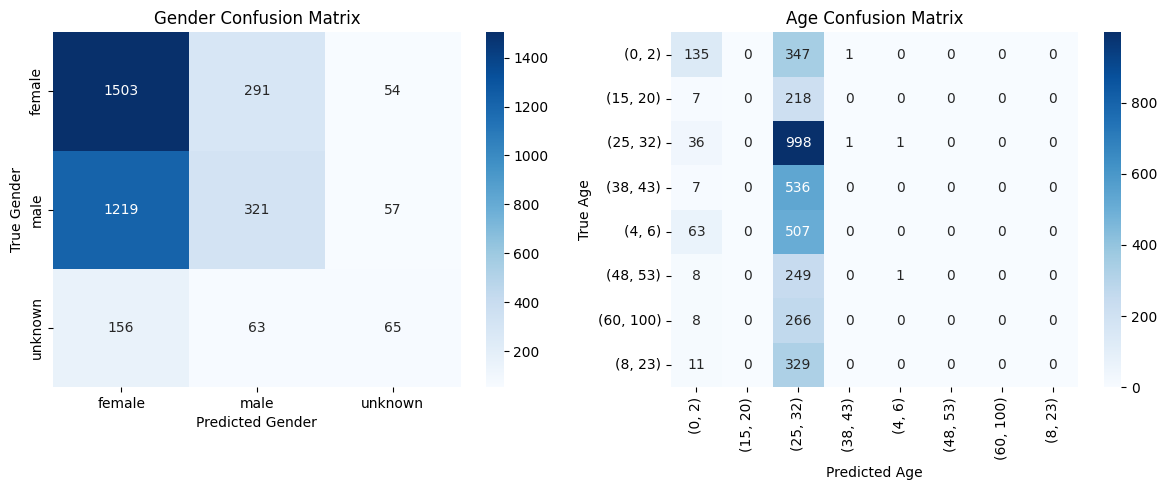

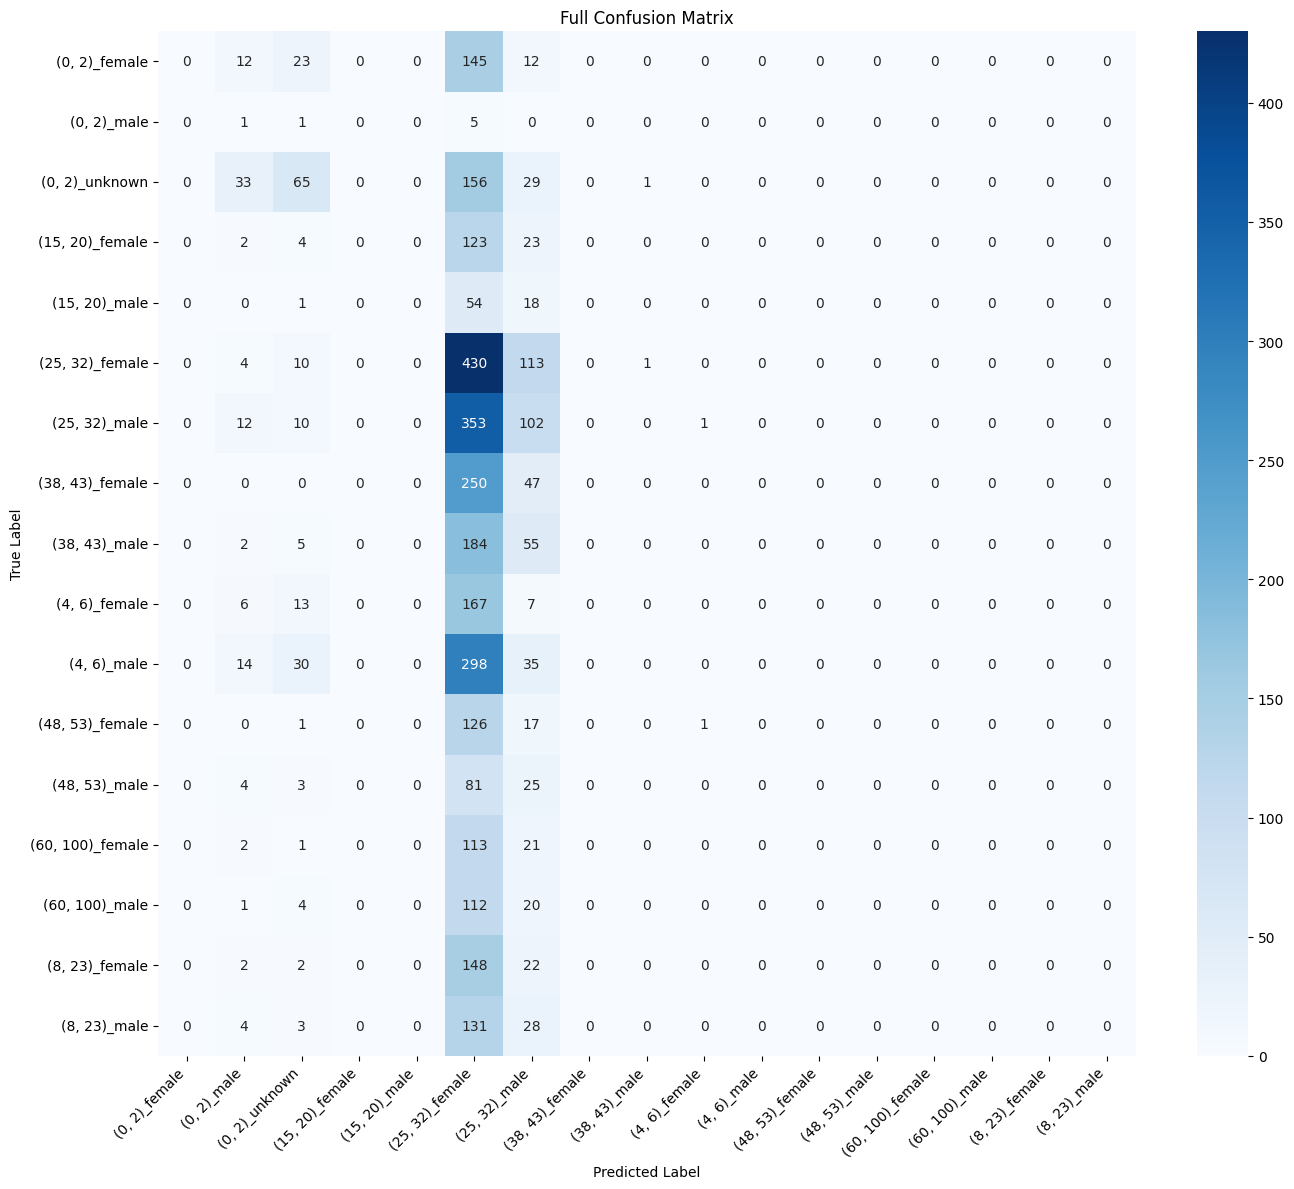

In [ ]:
# After training, we need to analyze results in a meaningful way
# Reset the generator and predict
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)


# Check the type of test_generator.labels and handle accordingly
print("test_generator.labels type:", type(test_generator.labels))
print("predictions shape:", predictions.shape)

# Convert to numpy array if it's a list
if isinstance(test_generator.labels, list):
    true_labels = np.array(test_generator.labels)
else:
    true_labels = test_generator.labels

# Now check the shape
if len(true_labels.shape) == 1:
    # Labels are already class indices (1D array)
    true_classes = true_labels
    print("Using 1D labels (indices)")
else:
    # Labels are one-hot encoded (2D array)
    true_classes = np.argmax(true_labels, axis=1)
    print("Using 2D labels (one-hot encoded)")


# Map indices back to class names
class_indices_rev = {v: k for k, v in test_generator.class_indices.items()}
predicted_class_names = [class_indices_rev[i] for i in predicted_classes]
true_class_names = [class_indices_rev[int(i)] for i in true_classes]  # Convert to int to be safe

# Print classification report
print(classification_report(true_classes, predicted_classes, 
                           target_names=list(test_generator.class_indices.keys())))

# Create confusion matrix for class indices
cm = confusion_matrix(true_classes, predicted_classes)
print(f"Confusion matrix shape: {cm.shape}")

# Extract age and gender from predictions for separate analysis
def extract_age_gender(class_name):
    parts = class_name.split('_')
    age = '_'.join(parts[:-1])  # Everything before the last underscore
    gender = parts[-1]          # Last part after the underscore
    return age, gender

# Calculate age-only and gender-only accuracy
true_ages = [extract_age_gender(class_indices_rev[int(i)])[0] for i in true_classes]
pred_ages = [extract_age_gender(class_indices_rev[i])[0] for i in predicted_classes]
true_genders = [extract_age_gender(class_indices_rev[int(i)])[1] for i in true_classes]
pred_genders = [extract_age_gender(class_indices_rev[i])[1] for i in predicted_classes]

print("\nAge-only accuracy:", accuracy_score(true_ages, pred_ages))
print("Gender-only accuracy:", accuracy_score(true_genders, pred_genders))

# Plot confusion matrices for age and gender separately
age_labels = sorted(set(true_ages))
gender_labels = sorted(set(true_genders))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_gender = confusion_matrix(true_genders, pred_genders, labels=gender_labels)
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues',
            xticklabels=gender_labels, yticklabels=gender_labels)
plt.title('Gender Confusion Matrix')
plt.ylabel('True Gender')
plt.xlabel('Predicted Gender')

plt.subplot(1, 2, 2)
cm_age = confusion_matrix(true_ages, pred_ages, labels=age_labels)
sns.heatmap(cm_age, annot=True, fmt='d', cmap='Blues',
            xticklabels=age_labels, yticklabels=age_labels)
plt.title('Age Confusion Matrix')
plt.ylabel('True Age')
plt.xlabel('Predicted Age')
plt.tight_layout()
plt.show()

# Optional: Plot overall confusion matrix if not too large
if len(class_indices_rev) <= 20:  # Only plot if not too many classes
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title('Full Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Save the Model
Finally, we can save the trained model for future use.

In [ ]:
model.save('resnet50_image_classification_model.h5')